<a href="https://colab.research.google.com/github/luismiguelcasadodiaz/IBM_SkillsBuild_IA_325/blob/main/IA_325_py_cod_ex_51_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación de Clientes y Predicción de Compra

## Contexto

Eres analista de datos en una empresa de comercio electrónico que quiere mejorar su estrategia de marketing mediante la **segmentación de clientes** y la **predicción de su intención de compra**.

Tu objetivo es crear un sistema que:

+ 1.- **Genere datos sintéticos** representativos de clientes reales, con variables como cuánto gastan, cuántas compras hacen, y con qué frecuencia compran.

+ 2.- **Segmente a los clientes** en grupos similares usando un algoritmo de clustering.

+ 3.- **Entrene un modelo predictivo** para estimar si un cliente comprará en el próximo mes basándose en sus características y el segmento al que pertenece.

+ 4.- **Visualice los segmentos y la probabilidad de compra** para facilitar la interpretación de los resultados.

<br>
<br>

## Datos proporcionados y estructura

+ Clase **CustomerDataGenerator**: Esta clase debe generar un DataFrame con 300 clientes sintéticos, cada uno con estas columnas:

  + total_spent: Dinero total gastado por el cliente, en euros (valor aleatorio entre 50 y 1500).

  + total_purchases: Número total de compras realizadas (entero entre 1 y 50).

  + purchase_frequency: Frecuencia de compra mensual (valor entre 0.5 y 10).

  + will_buy_next_month: Etiqueta binaria (1 o 0) que indica si el cliente comprará el próximo mes. La regla para asignar 1 es: si total_spent > 500 y purchase_frequency > 4, el cliente comprará (1), si no, no comprará (0).

<br>
<br>

## Modelado

+ Clase **CustomerSegmentationModel**. Esta clase debe:

  + Recibir el DataFrame generado.

  + Segmentar clientes en 3 grupos usando KMeans con las variables total_spent, total_purchases y purchase_frequency.

  + Añadir la columna customer_segment al DataFrame con el número de segmento asignado a cada cliente.

  + Entrenar un modelo de regresión logística para predecir will_buy_next_month, usando como variables las originales más la segmentación (transformada en variables dummy).

  + Proveer métodos para obtener la precisión del modelo y la matriz de confusión.

<br>
<br>

## Visualizaciones

  + Función graficar_segmentos(data):

    + Genera un scatter plot de total_spent vs purchase_frequency.

    + Usa colores diferentes para cada segmento.

    + Añade leyenda, etiquetas y título descriptivo.

  + Función graficar_probabilidad_compra(modelo):

    + Muestra cómo varía la probabilidad de compra del cliente en función del gasto total (total_spent), manteniendo constantes total_purchases=25 y purchase_frequency=5.

    + Dibuja la curva de probabilidad predicha por el modelo de regresión logística.



## Indicaciones numéricas y técnicas

+ Número de muestras: 300.
+ Número de clusters para KMeans: 3.
+ Random seed: 42 para reproducibilidad.
+ División de datos para entrenamiento/prueba: 80% / 20%.
+ Iteraciones máximas para la regresión logística: 500.
+ Uso solo de numpy, pandas, sklearn y matplotlib



## Ejemplo de uso
```python
# 1. Generar datos
generador = CustomerDataGenerator()
datos_clientes = generador.generate(300)

# 2. Crear modelo
modelo = CustomerSegmentationModel(datos_clientes)
modelo.segment_customers()
modelo.train_model()

# 3. Resultados
print("Precisión del modelo:", modelo.get_accuracy())
print("Matriz de confusión:\n", modelo.get_confusion_matrix())

# 4. Visualizaciones
graficar_segmentos(modelo.data)
graficar_probabilidad_compra(modelo.model)

```
Salida esperada
```python
Precisión del modelo: 0.8833333333333333
Matriz de confusión:
 [[30  2]
 [ 5 23]]
```






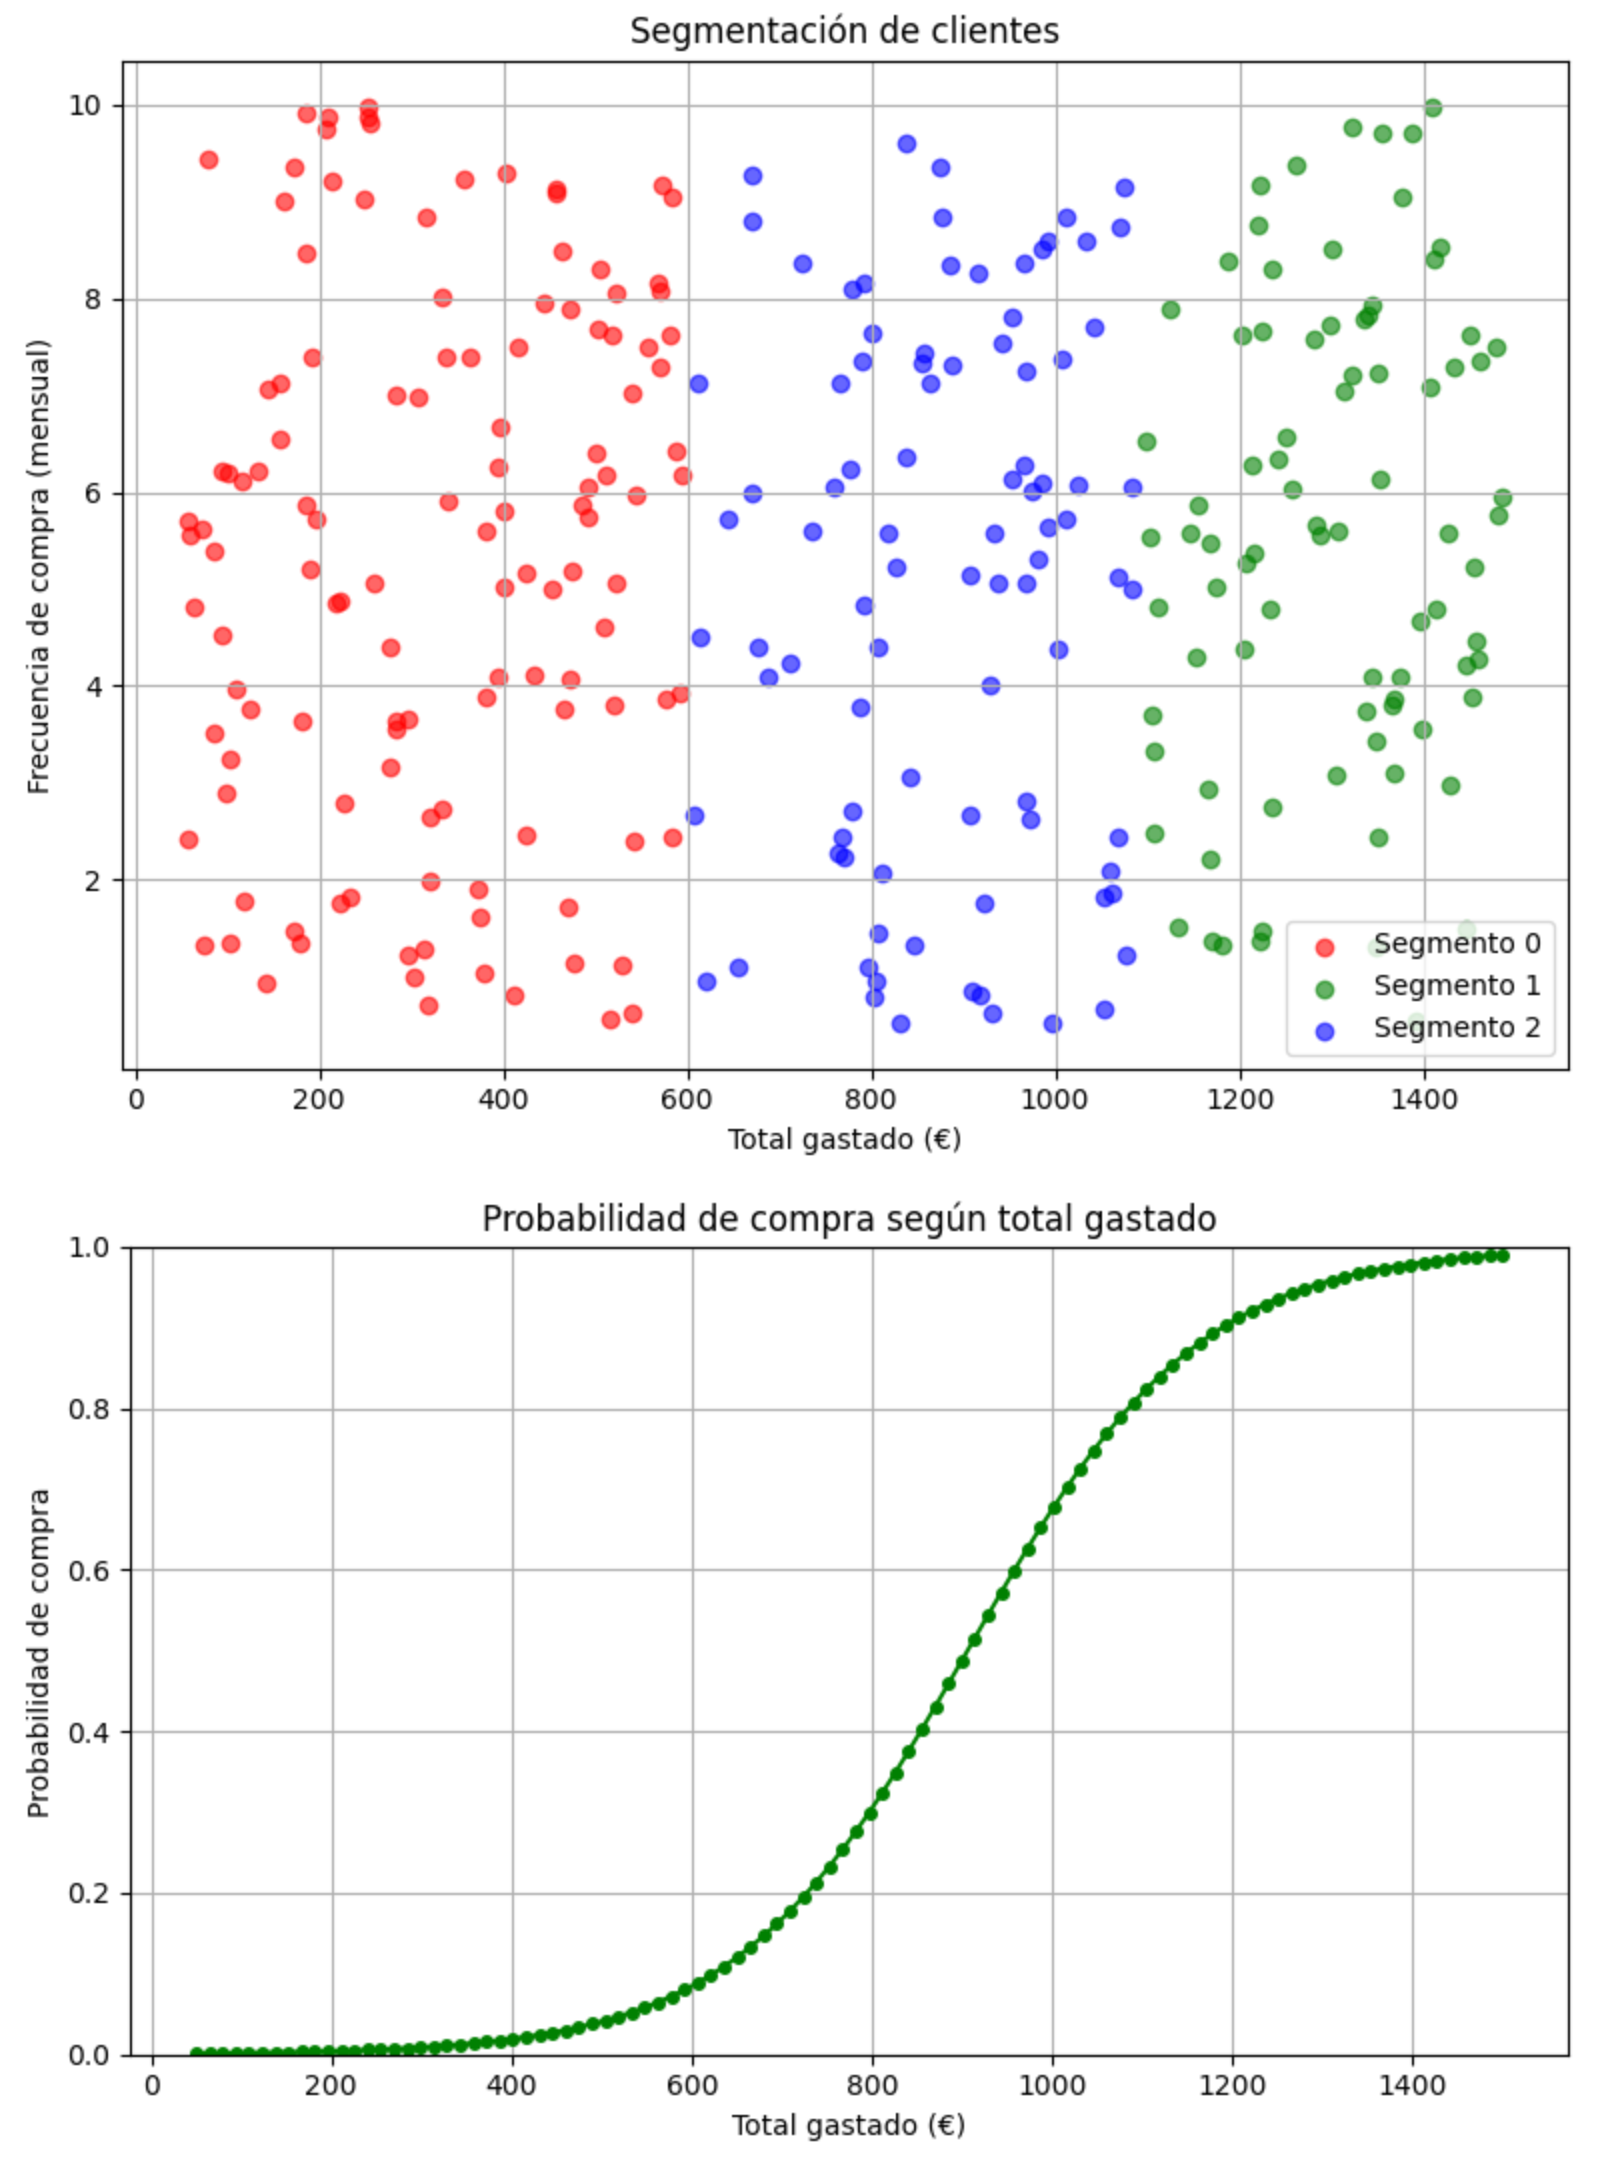

## Importación de las librerías

In [547]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# modelos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# funciones auxiliares
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

## Definición de la clase CustomerDataGenerator

In [548]:
class CustomerDataGenerator:
  def __init__(self):
    self.n_customers = None
  def generate(self, n_customers=300)->pd.DataFrame:
    self.n_customers = n_customers
    total_spent = np.random.randint(50, 1501, self.n_customers)
    total_purchases = np.random.randint(1, 51, self.n_customers)
    purchase_frequency = np.random.uniform(0.5, 11, self.n_customers)
    data = {'total_spent': total_spent, 'total_purchases': total_purchases, 'purchase_frequency': purchase_frequency}
    df = pd.DataFrame(data)
    df['will_buy_next_month'] =df.apply(lambda x: 1 if (x['total_spent'] > 500 and x['purchase_frequency'] > 4) else 0, axis=1)

    return df

In [549]:
cdg = CustomerDataGenerator()
df = cdg.generate(n_customers=5)
df.head()

,total_spent,total_purchases,purchase_frequency,will_buy_next_month
0,960,23,8.347128,1
1,150,27,8.087825,0
2,453,5,5.125162,0
3,456,12,9.051908,0
4,820,32,1.512491,0


## Definición de la clase CustomerSegmentationModel

In [550]:
class CustomerSegmentationModel:
  def __init__(self, data):
    self.df = data
    self.df_scaled = None
    self.df_encoded = None
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None
    self.y_pred = None
    self.scaler = None
    self.classifier = None
    self.forecaster = None
  def segment_customers(self, n_clusters =3 ):
    # scalamos los datos escalables (gasto, compra y freq )....
    # no escalamos la voluntad de comprar. Es la etiqueta de la regresion
    # logística y tiene que ser discreta y no continua

    self.scaler = StandardScaler()

    df_spent_purch_freq = self.df[['total_spent', 'total_purchases', 'purchase_frequency']]

    # el escalador recibe un dataframe y devuelve un numpy array.
    # hay que reconvertirlo en Dataframe. manteniendo los indices originales
    df_spent_purch_freq_scaled = pd.DataFrame(self.scaler.fit_transform(df_spent_purch_freq), \
                                              columns=df_spent_purch_freq.columns, \
                                              index=df_spent_purch_freq.index)

    # unimos las tres características escaladas con la no escalada
    self.df_scaled  = pd.concat([df_spent_purch_freq_scaled, self.df['will_buy_next_month']], axis=1)

    # Preparamos los datos para la clasificación en tres grupos
    df_segmentacion = self.df_scaled.drop('will_buy_next_month', axis=1)

    # Clasficamos los datos
    self.classifier = KMeans(n_clusters=n_clusters, random_state=0)
    self.classifier.fit(df_segmentacion)

    # Añadimos el grupo a cada cliente
    self.df_scaled['customer_segment'] = self.classifier.labels_
    self.df['customer_segment'] = self.classifier.labels_
    self.df_scaled.head()
    return

  def train_model(self):
    # Aplicamos la one-hot encoding a la variable 'cluster'
    self.df_encoded = pd.get_dummies(self.df_scaled, columns=['customer_segment'], drop_first=True)
    X = self.df_encoded.drop('will_buy_next_month', axis=1)
    y = self.df_encoded['will_buy_next_month']
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    self.forecaster = LogisticRegression()
    print(self.X_train.head())
    self.forecaster.fit(self.X_train, self.y_train)

    self.y_pred = self.forecaster.predict(self.X_test)

  def get_accuracy(self):
    return accuracy_score(self.y_test, self.y_pred)
  def get_confusion_matrix(self):
    return confusion_matrix(self.y_test, self.y_pred)

In [551]:
cdg = CustomerDataGenerator()
df = cdg.generate(n_customers=5)
df.head()
df_segmentacion = df.drop('will_buy_next_month', axis=1)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df_segmentacion)
df['customer_segment'] = kmeans.labels_
df.head()


,total_spent,total_purchases,purchase_frequency,will_buy_next_month,customer_segment
0,1177,40,8.848413,1,1
1,785,39,2.660741,0,1
2,85,13,7.118181,0,0
3,411,25,0.535947,0,0
4,1365,28,9.118260,1,1


In [552]:
   df_encoded = pd.get_dummies(df, columns=['customer_segment'])
   df_encoded.head()

,total_spent,total_purchases,purchase_frequency,will_buy_next_month,customer_segment_0,customer_segment_1
0,1177,40,8.848413,1,False,True
1,785,39,2.660741,0,False,True
2,85,13,7.118181,0,True,False
3,411,25,0.535947,0,True,False
4,1365,28,9.118260,1,False,True


## Definición de la función de visualizacion de la clasificación

In [553]:
def graficar_segmentos(df):
  plt.figure(figsize=(10, 6))
  segmentos = df['customer_segment'].unique()
  for segmento in segmentos:
    segmento_df = df[df['customer_segment'] == segmento]
    plt.scatter(segmento_df['total_spent'], segmento_df['total_purchases'], label=f'Segmento {segmento}', alpha=0.6)

  plt.xlabel("Total gastado (€)")
  plt.ylabel("Frecuencia de compra (mensual)")
  plt.title("Segmentación de clientes")



## Definición de la funcion de visualización de la prediccion de compra

In [554]:
def graficar_probabilidad_compra(forecaster):
  # Visualizamos la probabilidad en función de lo gastado

  # Generamos datos sinteticos para las tres variables, pero dejando dos fijas
  total_spent = np.linspace(50,1500, 100) # 100 datos distribuidos en rango
  total_purchases = np.full(100, 25)       # los 100 datos a 25
  purchase_frequency = np.full(100, 5)    # los 100 datos a 5

  X_entradas = pd.DataFrame({'total_spent': total_spent, \
                             'total_purchases': total_purchases, \
                             'purchase_frequency': purchase_frequency})

  # Generamos los datos de las variables dummy. Estamos en el segmento 0
  X_entradas['customer_segment_1'] = 0
  X_entradas['customer_segment_2'] = 0

  probabilidades = forecaster.predict_proba(X_entradas)
  probabilidad_comprar = probabilidades[:, 1] # Probabilidad de la clase 1 (comprar)


  plt.figure(figsize=(10, 6))
  plt.plot(total_spent, probabilidad_comprar, color='green', marker='o')
  plt.xlabel("Total gastado (€)")
  plt.ylabel("Probabilidad de compra")
  plt.title("Probabilidad de compra en función de lo gastado")
  plt.grid(True)
  plt.show()

## Ejemplo de uso

     total_spent  total_purchases  purchase_frequency  customer_segment_1  \
232     0.271371         0.521904            1.003344                True   
59      1.899209         0.521904           -0.913431               False   
6      -1.242445        -0.183372            0.802009                True   
185    -0.136195        -1.029702           -1.110178               False   
173     0.358707         0.945069            1.290661                True   

     customer_segment_2  
232               False  
59                 True  
6                 False  
185               False  
173               False  
Precisión del modelo: 0.8333333333333334
Matriz de confusión:
 [[29  5]
 [ 5 21]]


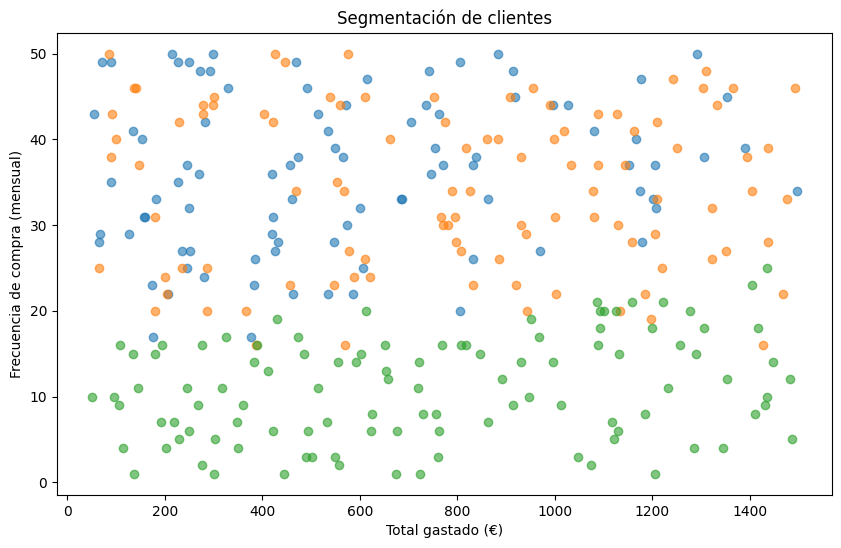

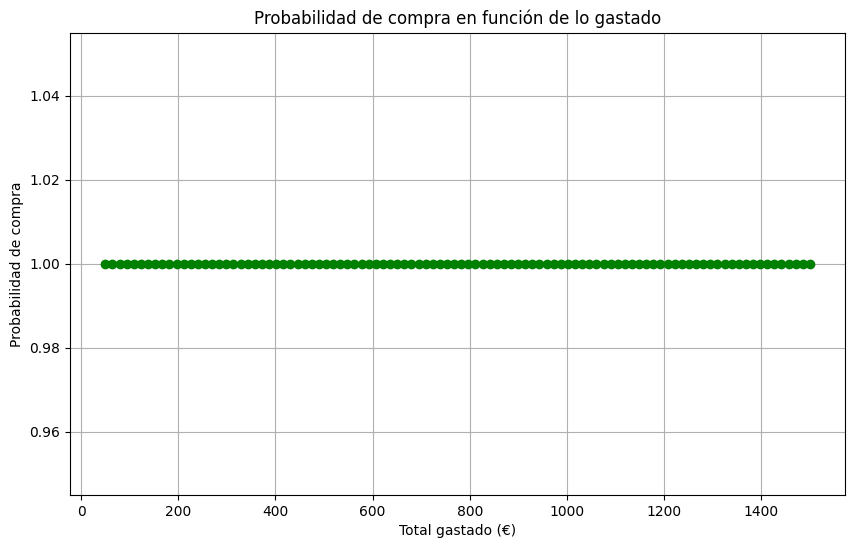

In [555]:
# 1. Generar datos
generador = CustomerDataGenerator()
datos_clientes = generador.generate(300)

# 2. Crear modelo
modelo = CustomerSegmentationModel(datos_clientes)
modelo.segment_customers(3)
modelo.train_model()

# 3. Resultados
print("Precisión del modelo:", modelo.get_accuracy())
print("Matriz de confusión:\n", modelo.get_confusion_matrix())



# 4. Visualizaciones
graficar_segmentos(modelo.df)
graficar_probabilidad_compra(modelo.forecaster)